<a href="https://colab.research.google.com/github/ca-scribner/quick_draw/blob/master/CCN_QD_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

The following trains a CNN-based classifier to distinguish between a 10-category subset of the Quick, Draw! dataset.  This notebook was run on a Google Colab instance and includes all commands necessary to aquire and process the data.  Some very high level discussion of results is included, but generally this was made more as a proof-of-concept reminder for me to come back to when I wanted to do something similar in a production setting. 

# Install and load necessary packages

In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
import tensorflow as tf
tf.executing_eagerly()

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Initialize settings

In [0]:
random_seed = 1
n_samples = 15000

names = [
    'The Eiffel Tower',
    'baseball',
    'calculator',
    'giraffe',
    'moon',
    'passport',
    'snowflake',
    'traffic light',
    'yoga',
    'zebra',
]

# 28x28 pixels, 1 channel
IMAGE_SHAPE = (28, 28, 1)

# Dataset settings
BUFFER_SIZE = 1000
BATCH_SIZE = 64

# Size of Validation dataset
VALIDATION_SIZE = 0.2

# Download load, and preprocess data

Access data like described [here](https://github.com/googlecreativelab/quickdraw-dataset#preprocessed-dataset)

In [4]:
for name in names:
  !gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/{name}.npy' .

Copying gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy...
- [1/1 files][100.8 MiB/100.8 MiB] 100% Done                                    
Operation completed over 1 objects/100.8 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/baseball.npy...
\ [1/1 files][101.2 MiB/101.2 MiB] 100% Done                                    
Operation completed over 1 objects/101.2 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/calculator.npy...
- [1/1 files][ 96.0 MiB/ 96.0 MiB] 100% Done                                    
Operation completed over 1 objects/96.0 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/giraffe.npy...
- [1/1 files][ 95.1 MiB/ 95.1 MiB] 100% Done                                    
Operation completed over 1 objects/95.1 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/moon.npy...
- [1/1 files][ 91.

Data loaders and processors pull all data files, reshape/scale data as necessary, and prepare data in a shuffled/batched tf.Dataset object.

In [0]:
def get_data(names=None, nSamples=1000, randomSeed=1, datapath="./data/",
             datasetPrefix="full_numpy_bitmap_", datasetExtension=".npy" ,
             data_shape=None):
    """
    Returns a Numpy array with the requested Quick, Draw! data from numpy data files, plus label->int map

    :param names: Names of drawings to be loaded
    :param nSamples: Number of samples to be loaded per named drawing
    :param randomSeed: If not False, Random seed passed to np.random.seed
    :param datapath: Path to Quick Draw drawing data (in .npy format)
    :param datasetPrefix, datasetExtension: Prefix and extension on filenames.  Filenames to be constructed as:
                                            datasetPrefix + name + datasetExtension

    :return: Tuple of: 
        data: Numpy array of loaded data
        labels: Numpy array of label integers
        nameDict: Dictionary mapping label name (key) to label integer (value)
    """
    datafiles = [os.path.join(datapath, datasetPrefix, name+datasetExtension) for name in names]
    nameDict = {}
    
    if randomSeed:
        np.random.seed(randomSeed)

    classNumber = 0
    for name, fname in zip(names, datafiles):
        nameDict[name] = classNumber
        print(f"Loading {nSamples} samples for {name} from {fname}")
        temp = np.load(fname).astype('float32')
        temp = temp[np.random.choice(temp.shape[0], nSamples, replace=False)]

        try:
            data = np.concatenate((data, temp))
            labels = np.concatenate((labels, np.ones(temp.shape[0], dtype='int') * classNumber))
        except NameError:
            data = temp
            labels = np.ones(temp.shape[0], dtype='int32') * classNumber
        
        classNumber += 1
    return data, labels, nameDict

  
def prepare_data(data, image_shape=None, ):
    if image_shape is None:
        image_shape = IMAGE_SHAPE
        
    # Scale and shift about 0
    data = data.copy() / (255.0 / 2) - 1
    
    # Reshape to image shape (adds color channel)
    data = data.reshape(-1, *image_shape)
    
    return data
  
def prepare_dataset(data, labels, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices((data, labels))

  # Randomize, but don't buffer all the data
  dataset = dataset.shuffle(buffer_size)

  # Serve data up in batches
  dataset = dataset.batch(batch_size)

  return dataset

In [6]:
data, labels, label2int = get_data(names=names, nSamples=n_samples, 
                                   randomSeed=random_seed, datasetPrefix='',
                                   datapath='./')
data = prepare_data(data)

# Use python 3.7's feature that dictionary keys are in insertion order
# to make a reverse map
int2label = [k for k in label2int.keys()]

Loading 15000 samples for The Eiffel Tower from ./The Eiffel Tower.npy
Loading 15000 samples for baseball from ./baseball.npy
Loading 15000 samples for calculator from ./calculator.npy
Loading 15000 samples for giraffe from ./giraffe.npy
Loading 15000 samples for moon from ./moon.npy
Loading 15000 samples for passport from ./passport.npy
Loading 15000 samples for snowflake from ./snowflake.npy
Loading 15000 samples for traffic light from ./traffic light.npy
Loading 15000 samples for yoga from ./yoga.npy
Loading 15000 samples for zebra from ./zebra.npy


Split the data into test and validation splits, then prepare into a tf.Dataset

In [0]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, 
                                                  test_size=VALIDATION_SIZE, 
                                                  random_state=random_seed,
                                                  stratify=labels)

In [0]:
dataset_train = prepare_dataset(X_train, y_train)
dataset_val = prepare_dataset(X_val, y_val)

# Visualize the data

Take a look at some random images

In [0]:
def draw_sketch(x, y=None, cmap='gray_r', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Only plot the first output channel...
    if len(x.shape) < 3:
        x = x.reshape(x.shape[0], x.shape[1], 1)
    ax.imshow(x[:, :, 0], cmap=cmap)
    
    if y is not None:
        ax.text(x.shape[0] * 0.1, x.shape[1] * 0.1, str(y), color='r')
    
    return ax

def draw_sketches(x, y=None, subplot_shape=None, fig=None, savefig=None, **kwargs):
    if subplot_shape is None:
        # Get subplotShape by the next round square
        temp = math.ceil(math.sqrt(x.shape[0]))
        subplot_shape = (temp, temp)
        
    if fig is None:
        fig, axs = plt.subplots(nrows=subplot_shape[0], ncols=subplot_shape[1], figsize=(subplot_shape[1]*2, subplot_shape[0]*2))
        
    for i in range(subplot_shape[0]):
        for j in range(subplot_shape[1]):
            k = i * subplot_shape[1] + j
            
            try:
                thisy = y[k]
            except TypeError:
                thisy = None
            
            draw_sketch(x[k], thisy, ax=axs[i, j], **kwargs)
            
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            
    if savefig:
        fig.savefig(savefig)
    
    return fig

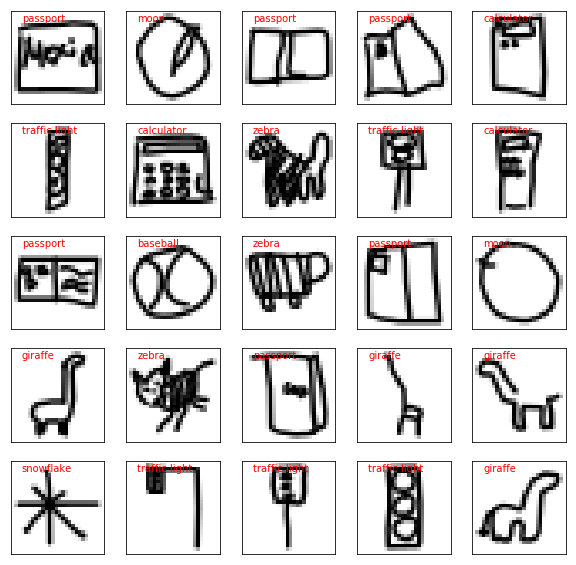

In [10]:
# Some random drawings
random_indices = np.random.choice(np.arange(data.shape[0]), size=25, replace=False)
these_labels = [int2label[labels[i]] for i in random_indices]
draw_sketches(x=data[random_indices], y=these_labels)
plt.show()

# Build the CNN Classifier

Define a constructor for the model which lets us vary hyperparameters as required (used for grid searching elsewhere)

In [0]:
def build_model(filters_1=16, kernel_size_1=None, dropout_1=0.25,
                filters_2=16, kernel_size_2=None, dropout_2=0.50,
                dense_layer_sizes=None, n_labels=1, output_activation=True):
  """
  Retruns an uncompiled tf.keras.Model
  
  Model includes:
    BatchNormalization between convolutional layers (cited to reduce training time
    by similar concept to normalizing inputs for NN's
    Dropout between convolutional layers to reduce overfitting
    LeakyReLU activation for inner layers to avoid vanishing gradients and dead neurons
    Optional activation on the output layer
      None if we want to use this as input for a loss function that prefers inputs as logits
      Sigmoid if we have a binary classification problem
      Softmax if we have a multi-class classification problem
  """
  
  if dense_layer_sizes == None:
    dense_layer_sizes = []

  if kernel_size_1 == None:
    kernel_size_1 = (5, 5)

  if kernel_size_2 == None:
    kernel_size_2 = (5, 5)

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=filters_1, kernel_size=kernel_size_1,
                                   strides=(1, 1), padding='same',
                                   input_shape=IMAGE_SHAPE))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout_1))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(filters=filters_2, kernel_size=kernel_size_2, 
                                   strides=(1, 1), padding='same') )
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout_2))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Flatten())

  for size in dense_layer_sizes:
    model.add(tf.keras.layers.Dense(size))
    model.add(tf.keras.layers.LeakyReLU())


  if n_labels == 2:
    print(f'Detected binary classification - overwriting n_labels to set to 1 (was {n_labels})')
    n_labels = 1

  if output_activation is True:
    if n_labels == 1:
    # Binary classification so use sigmoid if applying activation
      output_activation = 'sigmoid'
    else:
      # Multiclass classification so use softmax
      output_activation = 'softmax'
  elif not output_activation:
    output_activation = None
  model.add(tf.keras.layers.Dense(n_labels, activation=output_activation))

  return model

In [12]:
# Note that parameters were chosen through a binary classification grid search for parameters
# done separately
params = {
    'filters_1': 16,
    'kernel_size_1': (5, 5),
    'dropout_1': 0.25,
    'filters_2': 16,
    'kernel_size_2': (5, 5),
    'dropout_2': 0.5,
    'dense_layer_sizes': [16],
}

model = build_model(**params, n_labels=len(label2int), output_activation=True)
model.summary()


if len(names) <= 2:
  loss = 'binary_crossentropy'
else:
  # If we encode with labels ([0, 1, 2, ....]) then we use sparse_categorical_crossentropy
  loss = 'sparse_categorical_crossentropy'
  # If we encode with one-hot vectors ([[0, 0, 1, ... 0], [0, 1, 0, ... 0], ...]) then
  # we use categorical_crossentropy
#   loss = 'categorical_crossentropy'
  
model.compile(tf.keras.optimizers.Adam(),
              loss=loss,
             metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     min_delta=0,
                                     patience=10),
            ]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0

# Train the model

In [13]:
%%time
model.fit(x=dataset_train,
          validation_data=dataset_val,
          epochs=500,
          steps_per_epoch=None,
          callbacks=callbacks
          )

W0711 19:01:30.341227 139761488930688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
1875/1875 [==============================] - 22s 12ms/step - loss: 0.5776 - accuracy: 0.8202 - val_loss: 0.3650 - val_accuracy: 0.8893
Epoch 2/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4089 - accuracy: 0.8719 - val_loss: 0.3327 - val_accuracy: 0.8990
Epoch 3/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3780 - accuracy: 0.8816 - val_loss: 0.3092 - val_accuracy: 0.9059
Epoch 4/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3572 - accuracy: 0.8887 - val_loss: 0.2985 - val_accuracy: 0.9093
Epoch 5/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3458 - accuracy: 0.8930 - val_loss: 0.2927 - val_accuracy: 0.9101
Epoch 6/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3361 - accuracy: 0.8955 - val_loss: 0.2794 - val_accuracy: 0.9160
Epoch 7/500
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3300 - accuracy: 0.8980 - val_loss: 0

# Look at the predictions/results

Training gives us ~93% accuracy on the validation data.

Looking at the classification report, we can see all classes are classified reasonably well although some are better than others

In [15]:
# model.predict returns the softmax results for all categories.  Do an argmax across each row to get the actual chosen category
y_pred = model.predict(X_val).argmax(axis=-1)
print(classification_report(y_val, y_pred, target_names=names))

                  precision    recall  f1-score   support

The Eiffel Tower       0.97      0.97      0.97      3000
        baseball       0.93      0.92      0.92      3000
      calculator       0.92      0.95      0.94      3000
         giraffe       0.97      0.95      0.96      3000
            moon       0.94      0.92      0.93      3000
        passport       0.91      0.87      0.89      3000
       snowflake       0.94      0.95      0.95      3000
   traffic light       0.96      0.94      0.95      3000
            yoga       0.85      0.87      0.86      3000
           zebra       0.92      0.95      0.94      3000

        accuracy                           0.93     30000
       macro avg       0.93      0.93      0.93     30000
    weighted avg       0.93      0.93      0.93     30000



For example, the Eiffel Tower and Giraffes both have very high scores, whereas passports and yoga are lower (although still not bad...).  Looking at the confusion matrix we can see some interesting trends within the mistakes...

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    (Slightly modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)
    
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    classes = np.asarray(classes)
            
            # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Confusion matrix, without normalization


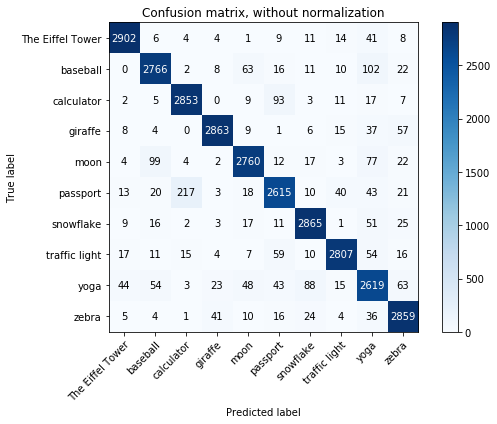

In [17]:
plot_confusion_matrix(y_val, y_pred, int2label)

Interestingly, a fair number of passports were classified as calculators (reading across the passport row we see how many actual passports were classified as each item (column)).  Meanwhile, yoga was mistaken for almost everything...